Specific about this notebook:
- Use data file sim_noisy_pulse.lc
- Fit the model on a subset (e.g. N/4) of the data, predict on the other 4-1 parts.
- Measure fit
- Downsampling using a Fourier method:
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from scipy import signal

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../../data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
##Plot the data

In [5]:
def plot_data(X, Y):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Plot observations
    plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"]);

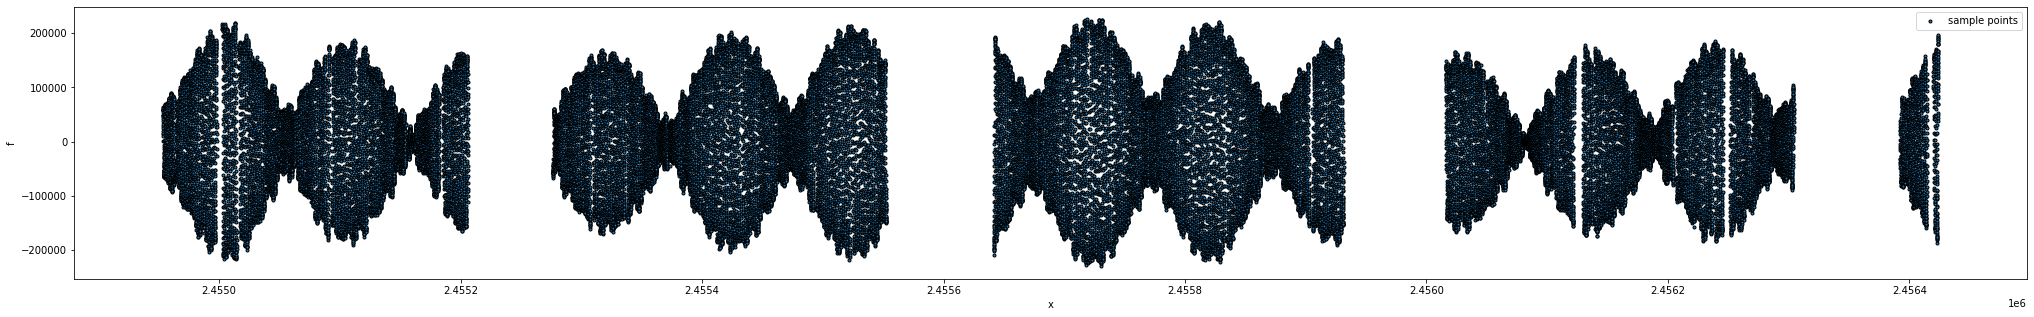

In [6]:
plot_data(X, Y)

## Downsample

In [7]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
N=X.shape[0]
N_sampled = 13000   # Use a number that can be divided by 4. N//4
X, Y = np.array(X), np.array(Y)
Y_part, X_part = signal.resample(x=Y, t=X, num=N_sampled)

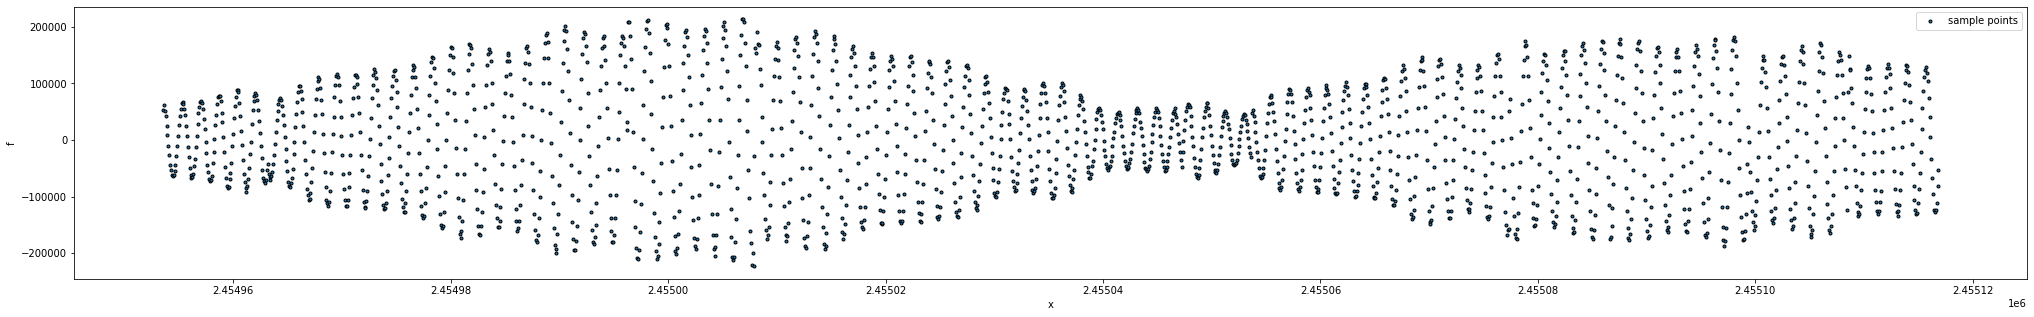

In [8]:
plot_data(X_part[:2000], Y_part[:2000])

# 2. Processing

Compose a Gaussian Process from a reasonable guess of kernels

## Select a subset for training the kernel

In [9]:
N_part = N_sampled

In [10]:
train_x=X_part
train_y=Y_part

## Fit the hyperparameters of a kernel


In [11]:
# Predict evenly spaced points on our time-axis
X_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

# You cannot use linspace again on N_Part, as there is an offset problem (N_part > N/4)
#train_x_smooth = np.linspace(train_x.min(),train_x.max(),N_part)
train_x_smooth = X_smooth
yerr = 0

In [12]:
# Initialize the S+LEAF model
# One stochastically-driven harmonic oscillator
## One Uncorrelated measurement errors (yerr)
cov_matrix = cov.Cov(train_x,
   sho = term.SHOKernel(sig=-0.04314, P0=1.7474, Q=8019.36505))

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# Define the function to minimize
def negloglike(x, y, cov_matrix):
   cov_matrix.set_param(x)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

# Fit
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(train_y, cov_matrix))

In [13]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest)
mu_part, var_part = cov_matrix.conditional(train_y, train_x_smooth, calc_cov='diag')

In [14]:
assert train_y.shape == mu_part.shape
assert mu_part.shape == var_part.shape

In [15]:
def plot_series(data_x, data_y, smooth_x, smooth_y, var):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
    plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()

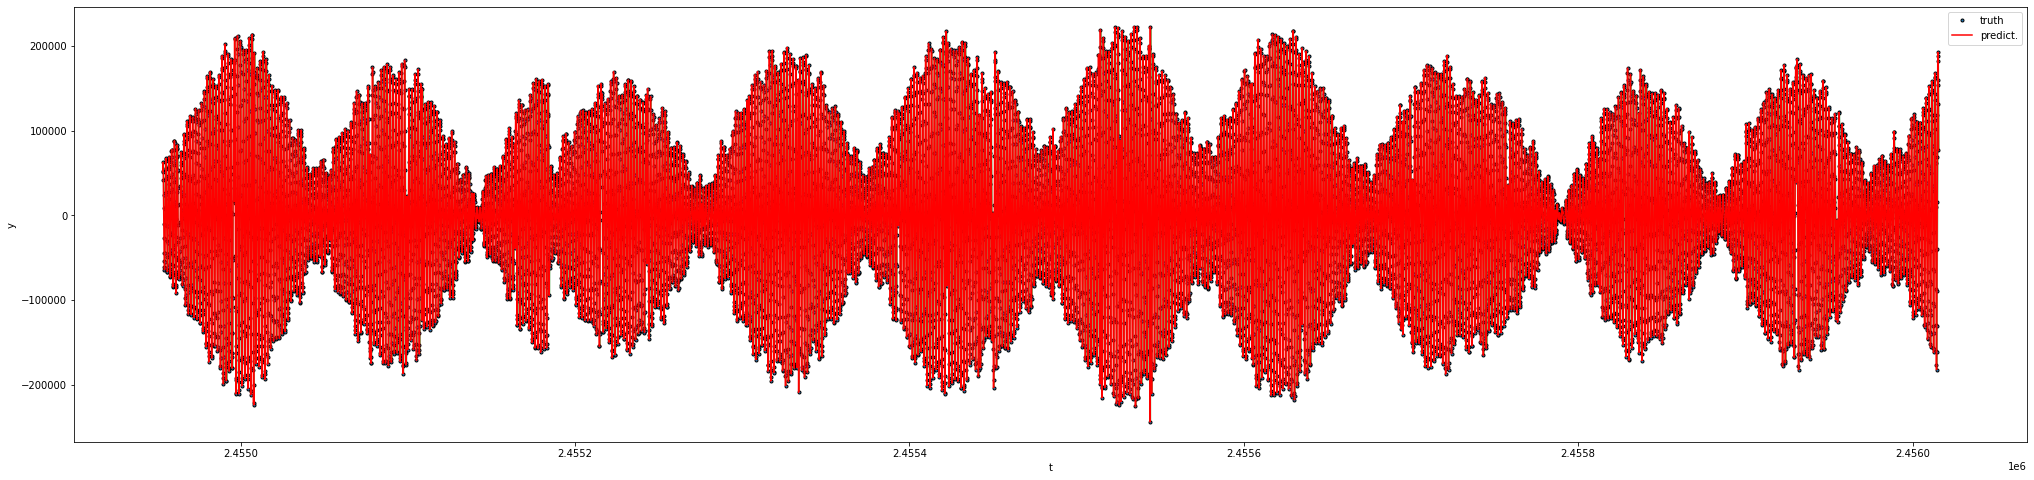

In [16]:
#plot_series(train_x, train_y, train_x_smooth, mu, var_part)
plot_series(train_x, train_y, train_x_smooth, mu_part, np.zeros(N_part))

## Explore the parameters of the fitted model

In [17]:
cov_matrix.param

['sho.sig', 'sho.P0', 'sho.Q']

In [18]:
sho_kern = cov_matrix.kernel['sho']
sho_kern

In [19]:
best_sig, best_P0, best_Q = cov_matrix.get_param('sho.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')
best_sig, best_P0, best_Q

(-6095.001333852048, 0.9437374598506024, 6621.748111013028)

## Model Evaluation

RMSE

In [20]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))

0.00011053791248591184

RMSE per x

In [21]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))/N

2.1268743262893833e-09